# COMPUTATIONAL SCIENCE PROJECT

# Enhancing Classical Nanoparticle Simulations with Electronic Corrections and Artificial Neural Networks.

In [1]:
%load_ext autoreload
%autoreload 2

This program utilises a number of machine learning methods implemented by the Scikit-Learn package.
https://scikit-learn.org/stable/

In [2]:
import numpy as np
import pandas as pd

from standard_vis import *

import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)

import os
import time
import matplotlib.pyplot as plt
import sys
import ast
import multiprocessing as mp
from copy import copy
from numpy import arange
from numpy import random

from scipy.spatial.distance import cdist,pdist
from scipy.stats import levene, pearsonr
from scipy import stats
from scipy.stats import uniform

from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn import utils
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils.multiclass import unique_labels

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterSampler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

#CLASSIFIERS
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree.export import export_text
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load the Data

In [3]:
X_df = pd.read_csv('../data/extracted_features.csv')

# Select training features by dropping excess target labels and other unused features
X_features = X_df.drop(['ID','Mermin_E', 'Delta_E', 'Delta_E/N', 'Fermi_L', 'CN_max', 'Classical_E/N', 'Classical_E', 'CLASS'], axis=1)

target_label = 'CLASS'
y_label = X_df[target_label]

X_feats = X_features.drop([
    # N_total kept as it improves results
    'R_min', # for correlation with N_shell/N_total
    'SCN_min', # for correlation with CN_min
    'SCN_avg', 'ABL_avg', 'BL_avg', # for correlation with CN_avg
    'ABL_avg', # For correlation with BL_avg
    'SBL_min', 'SBL_max', 'SBL_avg', 'SBL_std', 'SBL_skew', 'SBL_kurt', # for correlation with BL
    'ABA_kurt', # For correlation with ABA_skew
    'BA_kurt', # For correlation with BA_std and BA_skew
    'SBA_min', # For correlation with BA_min
    'BA_skew', # for correlation with SBA_kurt
    'SBA_skew', 'SBA_kurt' # For correlation with BA_skew, BA_kurt etc
], axis=1)

X_feats.describe()

,N_total,N_shell/N_total,R_max,R_avg,R_std,R_skew,R_kurt,CN_min,CN_avg,CN_std,...,ABA_avg,ABA_std,ABA_skew,BA_min,BA_max,BA_avg,BA_std,SBA_max,SBA_avg,SBA_std
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,630.658451,0.493737,16.178408,12.379082,1.425252,0.249665,-0.076445,4.140845,9.289648,2.027581,...,94.453633,4.546140,-1.489444,46.201426,179.718642,95.883292,34.310193,179.421020,92.500173,33.690448
std,230.863656,0.062088,3.192038,1.719876,0.768881,0.470275,1.290653,1.384373,0.812617,0.204524,...,0.642780,0.703678,0.324080,2.348440,0.270844,0.456833,0.685949,0.476239,0.595776,0.571362
min,236.000000,0.388330,9.665202,8.592114,0.485009,-0.771003,-1.424023,1.000000,7.191851,1.549891,...,91.809172,2.960429,-2.614211,38.696325,178.432356,93.780515,33.084558,177.200898,90.973333,32.488791
25%,438.750000,0.445095,14.066641,11.147761,0.860560,-0.047503,-0.698671,3.000000,8.596462,1.874227,...,94.062653,4.052686,-1.685696,45.079956,179.657873,95.549346,33.517871,179.259944,92.120192,33.250572
50%,598.000000,0.487849,16.144654,12.359336,1.157117,0.216507,-0.308612,4.000000,9.498588,2.011459,...,94.548696,4.539342,-1.483863,46.980238,179.809065,95.977161,34.610787,179.552941,92.515976,33.664868
75%,819.750000,0.535529,18.127391,13.753966,1.849234,0.501196,0.126800,5.000000,10.014101,2.195830,...,94.955922,5.002913,-1.288867,47.906385,179.896390,96.254189,34.903179,179.728773,92.886249,34.140185
max,1214.000000,0.736842,25.874050,16.031342,3.929259,2.532002,13.654322,6.000000,10.591549,2.442414,...,95.696520,6.332264,-0.323653,49.333752,179.994264,96.637302,35.238230,179.988261,94.560597,35.035268


In [4]:
X_scaled = RobustScaler().fit_transform(X_feats)
y_label = np.array(y_label).reshape(-1,1)

In [5]:
y_class = X_df['CLASS']

In [6]:
X1 = X_feats[y_class == 0]
X2 = X_feats[y_class == 1]
print(f'Class 1: {len(X1)}, Class 2: {len(X2)}')

Class 1: 103, Class 2: 181


In [7]:
X1['Classical_E'] = (X_df['Classical_E'][y_class == 0]).values
X2['Classical_E'] = (X_df['Classical_E'][y_class == 1]).values

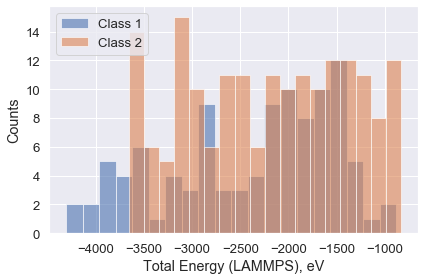

In [8]:
plt.figure(figsize=(6,4))
plt.hist(X1['Classical_E'], bins=20, alpha = 0.6, label='Class 1')
plt.hist(X2['Classical_E'], bins=18, alpha = 0.6, label='Class 2')
plt.legend(loc='upper left')
plt.xlabel('Total Energy (LAMMPS), eV')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

## Splitting the testing set and training set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.20, random_state=42)

## Decision Tree Classifier

In [10]:
param_dist = dict(splitter=['best','random'],
                  max_features=[None, 'auto','sqrt','log2'],
                  min_samples_split=stats.randint(2, 20),
                  min_samples_leaf=stats.randint(2, 20),
                  max_depth=stats.randint(1, 15),
                  criterion=['gini','entropy'],
                  ccp_alpha=[0,0.0001,0.001,0.01]
                 )

model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=None)

start = time.time()
clf = RandomizedSearchCV(model, param_dist, cv=10, n_iter=5000, random_state=42)
clf.fit(X_train, y_train)
stop = time.time()

print(f"Training time: {stop - start}s")

clf.best_params_


Training time: 182.43345141410828s


{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'splitter': 'random'}

In [11]:
model_DTC = tree.DecisionTreeClassifier(splitter='random',criterion='entropy', min_samples_leaf=3, min_samples_split=2, 
                                        max_features=None, max_depth=10,ccp_alpha=0.01, random_state=42)


start = time.time()
model_DTC.fit(X_train, y_train)

cv_scores = cross_val_score(model_DTC, X_train, y_train, cv=10)   
accuracy = np.mean(cv_scores)
uncertainty = np.std(cv_scores)*2
training_score = model_DTC.score(X_train, y_train)
testing_score = model_DTC.score(X_test, y_test)
stop = time.time()

print('Training score:', np.round(training_score, 6))
print('CV Scores:', np.round(cv_scores, 6))
print('Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")

Training score: 0.995595
CV Scores: [0.956522 0.956522 1.       0.913043 1.       0.956522 1.       1.
 1.       1.      ]
Accuracy: 0.978261 +/- 0.058332
Testing score: 0.964912
Training time: 0.03790688514709473s


## Classification report

In [12]:
y_pred = model_DTC.predict(X_test)

cm = multilabel_confusion_matrix(y_test, y_pred)

target_names = ['Class 1','Class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.96      0.96      0.96        23
     Class 2       0.97      0.97      0.97        34

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



### Confusion Matrix


<Figure size 1440x1440 with 0 Axes>

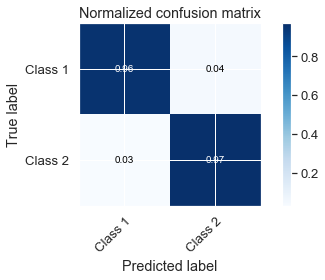

In [13]:
plot_confusion_matrix_(
    y_test, 
    y_pred, 
    np.array(['Class 1','Class 2']), 
    normalize=True, 
    cmap=plt.cm.Blues
)

plt.tight_layout()
plt.savefig("images/classifier-decision_tree_prediction_confusion_matrix.jpg", dpi=600, bbox_inches='tight')
plt.show()

## Learning curve

Training time: 7.842131614685059s


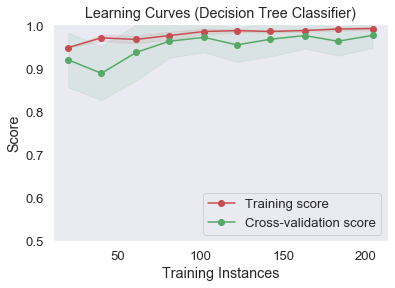

In [14]:
title = "Learning Curves (Decision Tree Classifier)"
estimator = model_DTC

start= time.time()
plot_learning_curve(estimator, title, X_train, y_train, \
                    ylim=(0.5, 1.005), cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
stop = time.time()
print(f"Training time: {stop - start}s")
plt.savefig("images/classifier-decision_tree_learning_curve.jpg", dpi=600, bbox_inches='tight')
plt.show()

### Feature importance profile

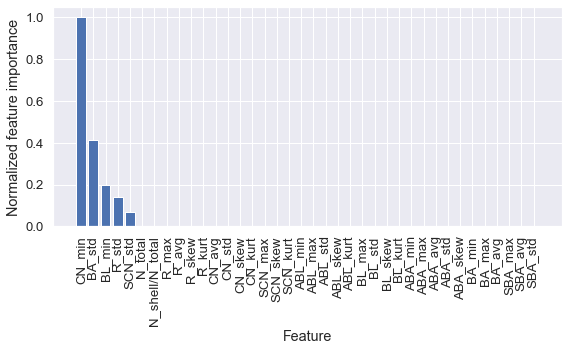

The important features are: ['CN_min', 'BA_std', 'BL_min', 'R_std', 'SCN_std']


In [15]:
X_feats.columns =(list(X_feats.columns.values) )
plot_feature_importance(
    X_feats.columns, 
    model_DTC.feature_importances_,
    show_cols = 42
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig("images/classifier-feature_importance_profile", dpi=600, bbox_inches='tight')
plt.show()
important_features = get_important_features(X_feats.columns, model_DTC.feature_importances_, cutoff = 0)
print("The important features are:",important_features)

In [16]:
import graphviz 
import pydotplus
import collections
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(model_DTC, out_file=None, 
                                feature_names=X_feats.columns, 
                                filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(dot_data) 
graph.render("images/classifier-decision-tree", format='png') 

'images\\classifier-decision-tree.png'

## ANN Classifier

Now we will train an artificial neural network (ANN).  We will use a Multilayer Perceptron.  

In [17]:
important_headers = important_features
Reduced_X_feats = X_feats [important_headers]
X_train, X_test, y_train, y_test = train_test_split(Reduced_X_feats, y_label, test_size=0.25, random_state=42)
X_train = np.array(X_train)

In [18]:
param_dist = dict(activation=["identity", "tanh", "relu", "logistic"],
                  alpha=np.logspace(-2, 2, num=10, base=10),
                  learning_rate=["adaptive","invscaling","constant"],
                  solver=[ "sgd", "adam", "lbfgs"],
                  max_iter=stats.randint(50, 500),
                  hidden_layer_sizes=[(),(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(3,2),(4,2,),(5,2,),(6,2,),(7,2,),
                                      (8,2,),(9,2,),(10,2,),(4,3,),(5,3,),(6,3,),(7,3,),(8,3,),(9,3,),(10,3,),
                                      (5,4,),(6,4,),(7,4,),(8,4,),(9,4,),(10,4,),(6,5,),(7,5,),(8,5,),(9,5,),(10,5,),
                                      (7,6,),(8,6,),(9,6,),(10,6,),(8,7,),(9,7,),(10,7,),(9,8,),(10,8,),(10,9,),
                                      (4,3,2),(5,3,2),(6,3,2),(7,3,2),(8,3,2),(9,3,2),(10,3,2),(5,4,2),(6,4,2),(7,4,2),
                                      (8,4,2),(9,4,2),(10,4,2),(6,5,2),(7,5,2),(8,5,2),(9,5,2),(10,5,2),(5,4,3),(6,4,3),
                                      (7,4,3),(8,4,3),(9,4,3),(10,4,3),(6,5,3),(7,5,3),(8,5,3),(9,5,3),(10,5,3), 
                                      (6,6,2),(7,6,2),(8,6,2),(9,6,2),(10,6,2),(8,7,2),(9,7,2),(10,7,2),
                                      (9,8,2),(10,8,2),(10,9,2),(7,6,3),(8,6,3),(9,6,3),(10,6,3),(8,7,3),
                                      (9,7,3),(10,7,3),(9,8,3),(10,8,3),(10,9,3),(7,6,4),(8,6,4),(9,6,4),
                                      (10,6,4),(8,7,4),(9,7,4),(10,7,4),(9,8,4),(10,8,4),(10,9,4)]
                 )
                  
model = MLPClassifier(early_stopping=True, random_state=42) # activation='identity'

start=time.time()
ann = RandomizedSearchCV(model, param_dist, cv=10, n_iter=1000, random_state=42)
ann.fit(X_train, y_train)
stop=time.time()

print(f"Training time: {stop - start}s")
ann.best_params_


Training time: 1261.763188123703s


{'activation': 'identity',
 'alpha': 0.01,
 'hidden_layer_sizes': (8, 5),
 'learning_rate': 'invscaling',
 'max_iter': 294,
 'solver': 'lbfgs'}

In [19]:
model_MLC = MLPClassifier(activation='identity', alpha=0.01, hidden_layer_sizes=(8, 5),
                                   learning_rate='invscaling',max_iter=294,solver='lbfgs', random_state=42)
model_MLC_no_hidden_layers = MLPClassifier(activation='identity', alpha=0.01, hidden_layer_sizes=(),
                                   learning_rate='invscaling',max_iter=294,solver='lbfgs', random_state=42)

start=time.time()
model_MLC.fit(X_train, y_train)

cv_scores = cross_val_score(model_MLC, X_train, y_train, cv=10)   
accuracy = np.mean(cv_scores)
uncertainty = np.std(cv_scores)*2
training_score = model_MLC.score(X_train, y_train)
testing_score = model_MLC.score(X_test, y_test)
stop = time.time()

print('With optimal hyperparameters:')
print('Training score:', np.round(training_score, 6))
print('CV Scores:', np.round(cv_scores, 6))
print('Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")

start=time.time()
model_MLC_no_hidden_layers.fit(X_train, y_train)

cv_scores = cross_val_score(model_MLC_no_hidden_layers, X_train, y_train, cv=10)   
accuracy = np.mean(cv_scores)
uncertainty = np.std(cv_scores)*2
training_score = model_MLC_no_hidden_layers.score(X_train, y_train)
testing_score = model_MLC_no_hidden_layers.score(X_test, y_test)
stop = time.time()

print('\nWith no hidden layers:')
print('Training score:', np.round(training_score, 6))
print('CV Scores:', np.round(cv_scores, 6))
print('Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")

With optimal hyperparameters:
Training score: 0.967136
CV Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy: 1.0 +/- 0.0
Testing score: 0.929577
Training time: 2.5998613834381104s

With no hidden layers:
Training score: 1.0
CV Scores: [0.954545 1.       1.       1.       1.       1.       1.       1.
 1.       0.952381]
Accuracy: 0.990693 +/- 0.037242
Testing score: 0.971831
Training time: 0.3341069221496582s


## Classification report and confusion matrix

In [20]:
y_pred = model_MLC_no_hidden_layers.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

target_names = ['Kinetic','Thermo']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Kinetic       1.00      0.93      0.96        28
      Thermo       0.96      1.00      0.98        43

    accuracy                           0.97        71
   macro avg       0.98      0.96      0.97        71
weighted avg       0.97      0.97      0.97        71



<Figure size 1440x1440 with 0 Axes>

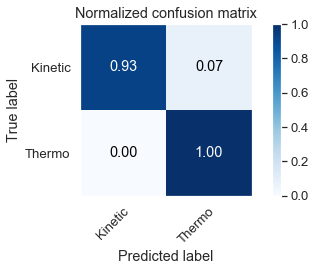

In [21]:
sns.set(font_scale=1.2)

plot_confusion_matrix_(
    y_test, 
    y_pred, 
    np.array(['Kinetic','Thermo']), 
    normalize=True, 
   title='', 
    #cmap=plt.cm.Blues
)

plt.tight_layout()
plt.grid(False)

plt.savefig("images/classifier-MLP_prediction_confusion_matrix.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [22]:
## Learning curve

Training time: 7.317533254623413s


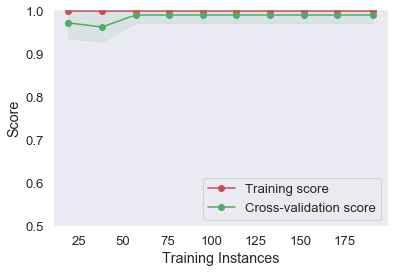

In [23]:
title = ""
estimator = model_MLC_no_hidden_layers

start= time.time()
plot_learning_curve(estimator, title, X_train, y_train, \
                    ylim=(0.5, 1.005), cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
stop = time.time()
print(f"Training time: {stop - start}s")
plt.savefig(f'images/classifier-LearningCurve_MLP.png', dpi = 600, bbox_inches='tight')
plt.show()

## Weights and biases

In [24]:
print ("Weights")
for i in range(len(model_MLC_no_hidden_layers.coefs_)):
    number_neurons_in_layer = model_MLC_no_hidden_layers.coefs_[i].shape[1]
    for j in range(number_neurons_in_layer):
        weights = model_MLC_no_hidden_layers.coefs_[i][:,j]
        print(i, j, weights, end=", ")
        print()
    print()

print ("Biases")
for i in range(len(model_MLC_no_hidden_layers.coefs_)):
    print(model_MLC_no_hidden_layers.intercepts_[i])
    print()

Weights
0 0 [ 3.1444785  10.51474932  7.51450935 -4.59918187 -7.85848774], 

Biases
[-371.87924647]

